# Squared coefficient of variation of the multiplexed window problem

Attempts are performed in batches. The process ends when the total number of successful attempts in the last $w$ batches is larger or equal to $n$.

Parameters:
 - $n$: total number of successes required.
 - $k$: number of attempts per batch.
 - $p$: probability of successful attempt.
 - $w$: window size (in number of batches).

Random variables:
 - $B$: number of batches until success.

In this notebook, we analyze the squared coefficient of variation of the window problem, a quantity that is needed to find the mean sojourn time in QCS.

In [1]:
import numpy as np
import math
import importlib as imp
import QCSsimulator as sim
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdmn
import matplotlib.ticker as ticker

&nbsp;
</br>
&nbsp;
</br>
&nbsp;
</br>


## Coefficient of variation of the service time

It can be shown that the coefficient of variation of the service time is larger than the coefficient of variation of the window problem. Here we test a small numerical example:

In [2]:
E_B = 20 # Expected value of number of batches until success
E_B2 = 450 # Expected value of squared number of batches until success
assert E_B2 >= E_B**2, 'Invalid parameters'

x = 44 # In our model, x=2L/c
y = 13 # In our model, y=t_fwd0*(2N+1)

# ----------------------
C_w2 = E_B2/E_B**2 - 1

E_Ts = x + y*E_B
E_Ts2 = x**2 + 2*x*y*E_B + y**2*E_B2

C_s2 = E_Ts2/E_Ts**2 - 1

print('Sq. Coeff. Var. (window):  %.3f'%C_w2)
print('Sq. Coeff. Var. (service): %.3f'%C_s2)

assert C_s2 <= C_w2

Sq. Coeff. Var. (window):  0.125
Sq. Coeff. Var. (service): 0.091


&nbsp;
</br>
&nbsp;
</br>
&nbsp;
</br>


## Coefficient of variation of the multiplexed window problem

The squared coefficient of variation of a positive random variable $X$ is defined as $$C(X)^2 = \frac{\mathrm{Var}(X)}{\left(\mathbb{E}[X]\right)^2}.$$

The estimate we use for the mean queueing time in M/G/k (necessary to find the mean sojourn time in sQCS) employs the squared coefficient of variation of the service time (this service time is given by the number of batches until completion of a multiplexed window problem). The estimate seems to be worse for large values of the coefficient ($C(X)\gg 1$), according to empirical data (see Gupta2010 and Whitt1993 (ref. 47 from Gupta2010)).

Below, we analyze the coefficient of variation of the multiplexed window problem. For practical reasons, we use our window problem simulator.

In [3]:
def compute_and_plot_C2(x_param,z_param,n,w,p,m,N_samples,N_experiments,randomseed,savefig,unbiased=True):

    np.random.seed(randomseed)
    random.seed(randomseed)

    if x_param == 'p':
        x_vec = p
    elif x_param == 'm':
        x_vec = m
    elif x_param == 'n':
        x_vec = n
    elif x_param == 'w':
        x_vec = w
        
    if z_param == 'p':
        z_vec = p
    elif z_param == 'm':
        z_vec = m
    elif z_param == 'n':
        z_vec = n
    elif z_param == 'w':
        z_vec = w
    elif z_param == 'nw':
        z_vec = n
        z2_vec = w
            
    cmap = plt.colormaps['inferno']
    colors = [cmap(i) for i in np.linspace(0,0.9,len(z_vec))]
    fig, ax = plt.subplots()
    
    for idx in tqdmn(range(len(z_vec)), leave='False'):
        if z_param == 'p':
            p = z_vec[idx]
        elif z_param == 'm':
            m = z_vec[idx]
        elif z_param == 'n':
            n = z_vec[idx]
        elif z_param == 'w':
            w = z_vec[idx]
        elif z_param == 'nw':
            n = z_vec[idx]
            w = z2_vec[idx]
        x_array_plot = []
        C2_vec = []
        C2_vec_stderr = []
        for x in x_vec:
            if x_param == 'p':
                p = x
            elif x_param == 'm':
                m = x
            elif x_param == 'n':
                n = x
            elif x_param == 'w':
                w = x
            if w*m < n:
                continue

            x_array_plot += [x]
            _C2_exp = []
            for N_exp in range(N_experiments):
                avg, std, stderr = sim.simulate_multiplexed_window_problem(n, m, w, p, N_samples, None)
                if unbiased:
                    _C2_exp += [((1+1/(4*N_samples))*std/avg)**2]
                else:
                    _C2_exp += [std**2/avg**2] # This is a biased estimator!!
            C2_vec += [np.mean(_C2_exp)]
            C2_vec_stderr += [np.std(_C2_exp)/np.sqrt(N_experiments)]

        if len(z_vec) <= 6 or (idx==0 or idx==len(z_vec)-1):
            if z_param == 'p':
                _label = r'$p = %.2f$'%p
            elif z_param == 'm':
                _label = r'$m = %d$'%m
            elif z_param == 'n':
                _label = r'$n = %d$'%n
            elif z_param == 'w':
                _label = r'$w = %d$'%w
            elif z_param == 'nw':
                _label = r'$n = %d, w = %d$'%(n,w)
        else:
                _label = ''
        plt.errorbar(x_array_plot, C2_vec, yerr=C2_vec_stderr,
                     marker='o', markersize=4, linestyle=':', capsize=3,
                     color=colors[idx], label=_label)

    # PLOT SPECS
    if x_param == 'p':
        x_label = r'Prob. successful delivery $p$'
    elif x_param == 'm':
        x_label = r'Attempts per batch $m$'
    elif x_param == 'n':
        x_label = r'Successes requested $n$'
    elif x_param == 'w':
        x_label = r'Window size $w$'
    plt.xlabel(x_label)
    plt.ylabel(r'Squared Coefficient of Variation')
    plt.xlim(x_array_plot[0],x_array_plot[-1])
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_ylim(top=1.05)
    
    #yticksvec = [0,0.2,0.4,0.6,0.8,1]
    #plt.yticks(ticks=yticksvec, labels=yticksvec)
    #ax.set_yticks(yticksvec, minor=True)
        
    # Major tick location
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])

    # Minor tick frequency
    y_minor_intervals = 2 # Number of minor intervals between two major ticks
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(y_minor_intervals))
    
    plt.legend()

    # SAVE
    if savefig:
        filename = 'figs/PAPER-Cwindow2'
        if (not n in [x_param, z_param]) and (not z_param=='nw'):
            filename += '-n%d'%n
        if (not w in [x_param, z_param]) and (not z_param=='nw'):
            filename += '-w%d'%w
        if not p in [x_param, z_param]:
            filename += '-p%.3f'%p
        if not m in [x_param, z_param]:
            filename += '-m%d'%m
        filename += '_Nsamples%d_Nexp%d_randseed%d.pdf'%(N_samples, N_experiments, randomseed)
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    else:
        plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

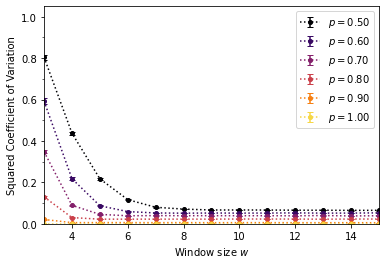

In [4]:
imp.reload(sim)

# Parameters
n = 7
m = 3
w = np.arange(3,16,1)
p = np.arange(0.5,1.01,0.1)

# Numerical parameters
N_samples = 1000
N_experiments = 10
randomseed = 2

# Plot
x_param = 'w'
z_param = 'p'
savefig = True

### ---------- ###
### ---------- ###

compute_and_plot_C2(x_param,z_param,n,w,p,m,N_samples,N_experiments,randomseed,savefig)

  0%|          | 0/6 [00:00<?, ?it/s]

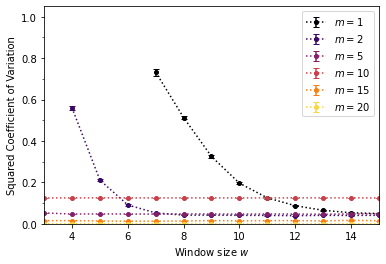

In [5]:
imp.reload(sim)

# Parameters
n = 7
m = [1,2]+list(np.arange(5,21,5))
w = np.arange(3,16,1)
p = 0.7

# Numerical parameters
N_samples = 1000
N_experiments = 10
randomseed = 2

# Plot
x_param = 'w'
z_param = 'm'
savefig = True

### ---------- ###
### ---------- ###

compute_and_plot_C2(x_param,z_param,n,w,p,m,N_samples,N_experiments,randomseed,savefig)

  0%|          | 0/4 [00:00<?, ?it/s]

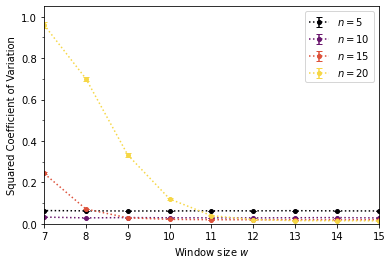

In [6]:
imp.reload(sim)

# Parameters
n = np.arange(5,21,5)
m = 3
w = np.arange(3,16,1)
p = 0.7

# Numerical parameters
N_samples = 1000
N_experiments = 10
randomseed = 2

# Plot
x_param = 'w'
z_param = 'n'
savefig = True

### ---------- ###
### ---------- ###

compute_and_plot_C2(x_param,z_param,n,w,p,m,N_samples,N_experiments,randomseed,savefig)

In [ ]:
imp.reload(sim)

# Parameters
n = [1]+list(np.arange(5,11,2))
m = 1 # C2 seems to be maximum for m=1
w = [1]+list(np.arange(5,21,5)) # C2 seems to be maximum for small w
p = np.linspace(0.2,1,10)

# Numerical parameters
N_samples = 1000
N_experiments = 10
randomseed = 2

# Plot
x_param = 'p'
z_param = 'nw'
savefig = True

### ---------- ###
### ---------- ###

compute_and_plot_C2(x_param,z_param,n,w,p,m,N_samples,N_experiments,randomseed,savefig)

  0%|          | 0/4 [00:00<?, ?it/s]